#BANKRUPTCY PREDICTION

In [2]:
import pandas as pd
import numpy as np

# Load the Excel file
file_path = "company_details.xlsx"
df = pd.read_excel(file_path)

# Display basic information and the first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11960 entries, 0 to 11959
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11956 non-null  object
 1   CMIE Expr     139 non-null    object
 2   CMIE Expr.1   12 non-null     object
 3   CMIE Expr.2   57 non-null     object
 4   CMIE Expr.3   6658 non-null   object
 5   CMIE Expr.4   7303 non-null   object
 6   CMIE Expr.5   10 non-null     object
 7   CMIE Expr.6   7368 non-null   object
 8   CMIE Expr.7   7840 non-null   object
 9   CMIE Expr.8   7782 non-null   object
 10  CMIE Expr.9   132 non-null    object
 11  CMIE Expr.10  12 non-null     object
 12  CMIE Expr.11  55 non-null     object
 13  CMIE Expr.12  6414 non-null   object
 14  CMIE Expr.13  7033 non-null   object
 15  CMIE Expr.14  10 non-null     object
 16  CMIE Expr.15  7095 non-null   object
 17  CMIE Expr.16  7621 non-null   object
 18  CMIE Expr.17  7558 non-null   object
 19  CMIE

(None,
      Unnamed: 0                                CMIE Expr  \
 0           NaN                                      NaN   
 1           NaN                Annual Finance Standalone   
 2           NaN                                Rs. Crore   
 3           NaN                      2019-12-01 00:00:00   
 4  Company Name  Deposits (accepted by commercial banks)   
 
                  CMIE Expr.1  \
 0                        NaN   
 1  Annual Finance Standalone   
 2                  Rs. Crore   
 3        2019-12-01 00:00:00   
 4         Net Tier I capital   
 
                                          CMIE Expr.2  \
 0                                                NaN   
 1                          Annual Finance Standalone   
 2                                                (%)   
 3                                2019-12-01 00:00:00   
 4  Tier I capital adequacy ratio of the bank (%) ...   
 
                  CMIE Expr.3                CMIE Expr.4  \
 0                   

In [3]:
import pandas as pd
import io

# 1. Reload & strip out initial metadata rows/empty columns
raw = pd.read_excel(file_path, header=None)
header_row = 4
new_columns = raw.iloc[header_row].tolist()
cleaned = raw.iloc[header_row+1:].copy()
cleaned.columns = new_columns
cleaned = cleaned.dropna(axis=1, how='all').reset_index(drop=True)

# 2. Identify last two columns (non-metric) and rename them
last_two_cols = cleaned.iloc[:, -2:].copy()
last_two_cols.columns = ["Suspended Date", "Delisted Date"]  # ✅ Explicit names

# 3. Core data (metrics only)
core_data = cleaned.iloc[:, :-2]

# 4. Drop columns from core_data with <30% non-null values
n_rows = core_data.shape[0]
min_non_null_cols = 0.30 * n_rows
core_pruned = core_data.dropna(axis=1, thresh=min_non_null_cols)

# 5. Drop rows with <40% non-null values (in core data only)
n_cols_core = core_pruned.shape[1]
min_non_null_rows = 0.40 * n_cols_core
row_mask = core_pruned.notna().sum(axis=1) >= min_non_null_rows

# 6. Apply row mask to both datasets (core and last two columns)
core_final = core_pruned[row_mask].reset_index(drop=True)
last_two_final = last_two_cols[row_mask].reset_index(drop=True)

# 7. Concatenate final datasets (core metrics + non-metrics)
cleaned_final = pd.concat([core_final, last_two_final], axis=1)

# 8. Inspect results
buf = io.StringIO()
print("==== After Column Pruning (Core Data) ====")
core_pruned.info(buf=buf)
print(buf.getvalue())

buf = io.StringIO()
print("==== After Row Pruning (Final Data) ====")
cleaned_final.info(buf=buf)
print(buf.getvalue())

print("\nPruned DataFrame (first 5 rows):")
print(cleaned_final.head())


==== After Column Pruning (Core Data) ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11956 entries, 0 to 11955
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NaT                  11956 non-null  object
 1   2019-12-01 00:00:00  6655 non-null   object
 2   2019-12-01 00:00:00  7300 non-null   object
 3   2019-12-01 00:00:00  7365 non-null   object
 4   2019-12-01 00:00:00  7837 non-null   object
 5   2019-12-01 00:00:00  7779 non-null   object
 6   2020-12-01 00:00:00  6411 non-null   object
 7   2020-12-01 00:00:00  7030 non-null   object
 8   2020-12-01 00:00:00  7092 non-null   object
 9   2020-12-01 00:00:00  7618 non-null   object
 10  2020-12-01 00:00:00  7555 non-null   object
 11  2021-12-01 00:00:00  6256 non-null   object
 12  2021-12-01 00:00:00  6860 non-null   object
 13  2021-12-01 00:00:00  6933 non-null   object
 14  2021-12-01 00:00:00  7431 non-null   object
 15  2021-12-01

In [4]:
# ---------- Metric Aggregation Starts Here ----------

# Step 8: Define metric and non-metric columns
non_metric_cols = ["Suspended Date", "Delisted Date"]
metric_cols = cleaned_final.columns[1:-2]  # All except Company Name and last 2

# Step 9: Extract metric names from first row (row 0)
metrics = cleaned_final.iloc[0, 1:-2]  # These are your metric labels
years = pd.to_datetime(metric_cols, errors='coerce').year  # Extract years

# Step 10: Skip row 0 and extract numeric values
data_num = cleaned_final.iloc[1:, 1:-2].apply(pd.to_numeric, errors='coerce')
data_num.columns = pd.MultiIndex.from_arrays([years, metrics], names=["Year", "Metric"])

# Step 11: Set company names as index (also skipping row 0)
companies = cleaned_final.iloc[1:, 0].reset_index(drop=True)
data_num.index = companies

# Step 12: Compute 5-year averages for each metric
result = pd.DataFrame(index=data_num.index)

for metric in data_num.columns.get_level_values("Metric").unique():
    dfm = data_num.xs(metric, axis=1, level="Metric")
    result[f"{metric}_5yr_avg"] = dfm.mean(axis=1, skipna=True)

# Step 13: Add back the non-metric columns (also skipping row 0)
non_metric_data = cleaned_final.iloc[1:, -2:].reset_index(drop=True)
non_metric_data.columns = non_metric_cols
result = pd.concat([result.reset_index(drop=True), non_metric_data], axis=1)

# Step 14: Final inspection
print("✅ Final shape:", result.shape)
print("✅ Columns:", result.columns.tolist())
print(result.info())
print(result.head())

✅ Final shape: (7412, 7)
✅ Columns: ['Total income_5yr_avg', 'Total expenses_5yr_avg', 'Profit after tax_5yr_avg', 'Total liabilities_5yr_avg', 'Total assets_5yr_avg', 'Suspended Date', 'Delisted Date']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Total income_5yr_avg       6984 non-null   float64
 1   Total expenses_5yr_avg     7317 non-null   float64
 2   Profit after tax_5yr_avg   7339 non-null   float64
 3   Total liabilities_5yr_avg  7412 non-null   float64
 4   Total assets_5yr_avg       7407 non-null   float64
 5   Suspended Date             60 non-null     object 
 6   Delisted Date              93 non-null     object 
dtypes: float64(5), object(2)
memory usage: 405.5+ KB
None
   Total income_5yr_avg  Total expenses_5yr_avg  Profit after tax_5yr_avg  \
0                0.7650                  0.1950    

In [5]:
result.describe()

,Total income_5yr_avg,Total expenses_5yr_avg,Profit after tax_5yr_avg,Total liabilities_5yr_avg,Total assets_5yr_avg
count,6984.000000,7317.000000,7339.000000,7.412000e+03,7.407000e+03
mean,402.905931,334.755355,49.308614,4.382342e+03,4.386435e+03
std,5954.215720,5113.573914,841.385549,7.742110e+04,7.744728e+04
min,-1.128000,-1.247500,-5743.938000,0.000000e+00,0.000000e+00
25%,0.230000,0.206000,-0.125000,5.053875e+00,5.082750e+00
50%,1.586000,1.390000,0.050000,2.358700e+01,2.368000e+01
75%,15.268750,13.872000,1.573250,1.302645e+02,1.303017e+02
max,354725.668000,319148.942000,39851.238000,5.042831e+06,5.042831e+06


In [6]:
# 1. Identify numeric and non-numeric parts safely
all_cols = result.columns
metric_cols = [col for col in all_cols if '_5yr_avg' in str(col)]
non_metric_cols = [col for col in all_cols if col not in metric_cols]

# 2. Rename non-metric columns if they are unnamed or 'NaT'
clean_non_metrics = result[non_metric_cols].copy()
clean_non_metrics.columns = [f'Info_{i+1}' if (not str(c) or str(c) == 'NaT') else c for i, c in enumerate(clean_non_metrics.columns)]

# 3. Fill only numeric metric columns
result_filled_metrics = result[metric_cols].fillna(result[metric_cols].median())

# 4. Concatenate clean numeric and non-numeric data
result_filled = pd.concat([result_filled_metrics, clean_non_metrics], axis=1)

# 5. Check
print(result_filled.info())
print(result_filled.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Total income_5yr_avg       7412 non-null   float64
 1   Total expenses_5yr_avg     7412 non-null   float64
 2   Profit after tax_5yr_avg   7412 non-null   float64
 3   Total liabilities_5yr_avg  7412 non-null   float64
 4   Total assets_5yr_avg       7412 non-null   float64
 5   Suspended Date             60 non-null     object 
 6   Delisted Date              93 non-null     object 
dtypes: float64(5), object(2)
memory usage: 405.5+ KB
None
   Total income_5yr_avg  Total expenses_5yr_avg  Profit after tax_5yr_avg  \
0                0.7650                  0.1950                    0.5700   
1                3.3675                  1.7950                    1.5725   
2                0.0300                  0.0120                    0.0120   
3                0.1050

In [7]:
result_filled.describe()

,Total income_5yr_avg,Total expenses_5yr_avg,Profit after tax_5yr_avg,Total liabilities_5yr_avg,Total assets_5yr_avg
count,7412.000000,7412.000000,7412.000000,7.412000e+03,7.412000e+03
mean,379.732033,330.482594,48.823471,4.382342e+03,4.383492e+03
std,5780.483200,5080.831701,837.245509,7.742110e+04,7.742123e+04
min,-1.128000,-1.247500,-5743.938000,0.000000e+00,0.000000e+00
25%,0.256000,0.210000,-0.122000,5.053875e+00,5.095500e+00
50%,1.586000,1.390000,0.050000,2.358700e+01,2.368000e+01
75%,12.986500,13.178500,1.503000,1.302645e+02,1.302645e+02
max,354725.668000,319148.942000,39851.238000,5.042831e+06,5.042831e+06


In [8]:
# Start with result_filled from earlier
df_feat = result_filled.copy()

# Derived ratios
df_feat["Profit_margin"]   = df_feat["Profit after tax_5yr_avg"] / df_feat["Total income_5yr_avg"]
df_feat["Expense_ratio"]   = df_feat["Total expenses_5yr_avg"] / df_feat["Total income_5yr_avg"]
df_feat["Asset_turnover"]  = df_feat["Total income_5yr_avg"] / df_feat["Total assets_5yr_avg"]
df_feat["ROA"]             = df_feat["Profit after tax_5yr_avg"] / df_feat["Total assets_5yr_avg"]
df_feat["Operating_margin"] = (df_feat["Total income_5yr_avg"] - df_feat["Total expenses_5yr_avg"]) / df_feat["Total income_5yr_avg"]
df_feat["Liability_to_income"] = df_feat["Total liabilities_5yr_avg"] / df_feat["Total income_5yr_avg"]

# Optional binary risk flags
df_feat["is_negative_profit"] = (df_feat["Profit after tax_5yr_avg"] < 0).astype(int)
df_feat["is_low_margin"]      = (df_feat["Profit_margin"] < 0.05).astype(int)


In [9]:
print("New shape:", df_feat.shape)
print(df_feat.info())
print(df_feat.head())
print(df_feat.tail())


New shape: (7412, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Total income_5yr_avg       7412 non-null   float64
 1   Total expenses_5yr_avg     7412 non-null   float64
 2   Profit after tax_5yr_avg   7412 non-null   float64
 3   Total liabilities_5yr_avg  7412 non-null   float64
 4   Total assets_5yr_avg       7412 non-null   float64
 5   Suspended Date             60 non-null     object 
 6   Delisted Date              93 non-null     object 
 7   Profit_margin              7412 non-null   float64
 8   Expense_ratio              7412 non-null   float64
 9   Asset_turnover             7412 non-null   float64
 10  ROA                        7412 non-null   float64
 11  Operating_margin           7412 non-null   float64
 12  Liability_to_income        7412 non-null   float64
 13  is_negative_profit        

In [10]:
# Use delisted/suspended status as proxy label (caution: not 100% reliable)
df_feat['Bankrupt'] = ((~df_feat['Delisted Date'].isna()) | (~df_feat['Suspended Date'].isna())).astype(int)

# Distribution of non-bankrupt (0) and bankrupt (1) companies
print(df_feat['Bankrupt'].value_counts())

Bankrupt
0    7282
1     130
Name: count, dtype: int64


In [11]:
print(df_feat.columns)

Index(['Total income_5yr_avg', 'Total expenses_5yr_avg',
       'Profit after tax_5yr_avg', 'Total liabilities_5yr_avg',
       'Total assets_5yr_avg', 'Suspended Date', 'Delisted Date',
       'Profit_margin', 'Expense_ratio', 'Asset_turnover', 'ROA',
       'Operating_margin', 'Liability_to_income', 'is_negative_profit',
       'is_low_margin', 'Bankrupt'],
      dtype='object')


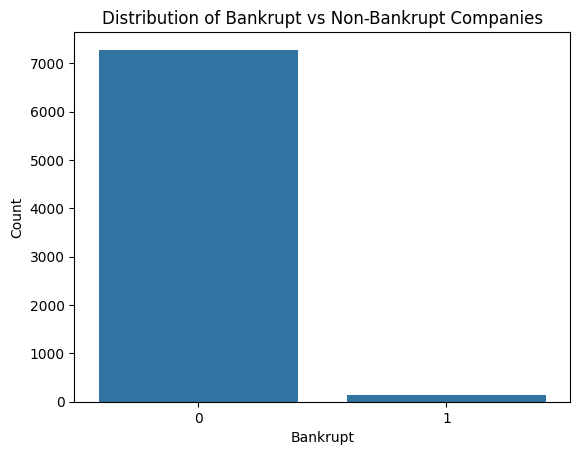

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Bankrupt", data=df_feat)
plt.title("Distribution of Bankrupt vs Non-Bankrupt Companies")
plt.xlabel("Bankrupt")
plt.ylabel("Count")
plt.show()


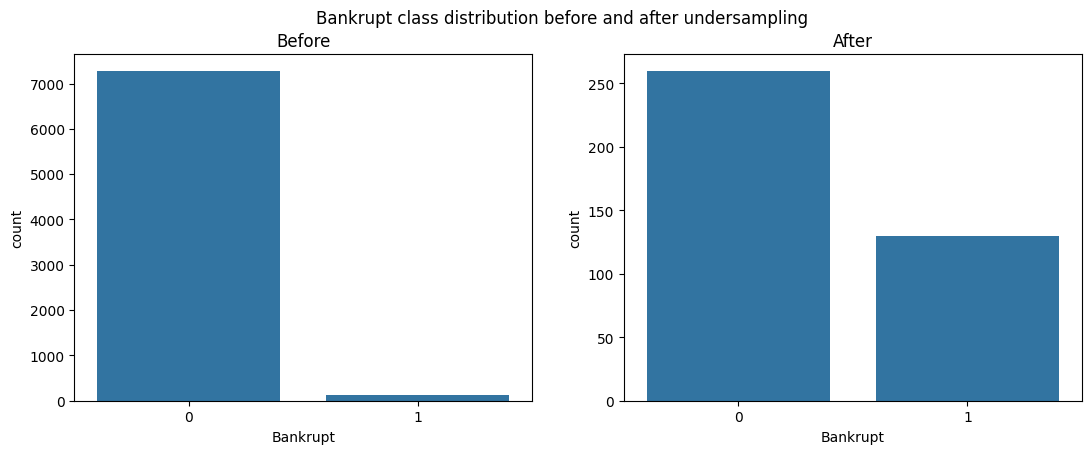

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Define selected features
features = [
    'Profit_margin', 'Expense_ratio', 'Asset_turnover', 'ROA',
    'Operating_margin', 'Liability_to_income',
    'is_negative_profit', 'is_low_margin',
    'Total income_5yr_avg', 'Total expenses_5yr_avg',
    'Profit after tax_5yr_avg', 'Total liabilities_5yr_avg'
]
target = "Bankrupt"

X = df_feat[features]
Y = df_feat[target]

# Apply undersampling (0.5 means 1 bankrupt for every 2 non-bankrupts)
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_under, Y_under = undersample.fit_resample(X, Y)

# Convert to DataFrame for visualization
test = pd.DataFrame(Y_under, columns=["Bankrupt"])

# Visualize class distribution before and after undersampling
fig, axs = plt.subplots(ncols=2, figsize=(13, 4.5))
sns.countplot(x="Bankrupt", data=df_feat, ax=axs[0])
sns.countplot(x="Bankrupt", data=test, ax=axs[1])

fig.suptitle("Bankrupt class distribution before and after undersampling")
axs[0].set_title("Before")
axs[1].set_title("After")
plt.show()


✅ Accuracy: 0.6025641025641025

📉 Confusion Matrix:
 [[37 17]
 [14 10]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.70        54
           1       0.37      0.42      0.39        24

    accuracy                           0.60        78
   macro avg       0.55      0.55      0.55        78
weighted avg       0.62      0.60      0.61        78

Precision: 0.37037037037037035
Recall: 0.4166666666666667
F1 Score: 0.39215686274509803


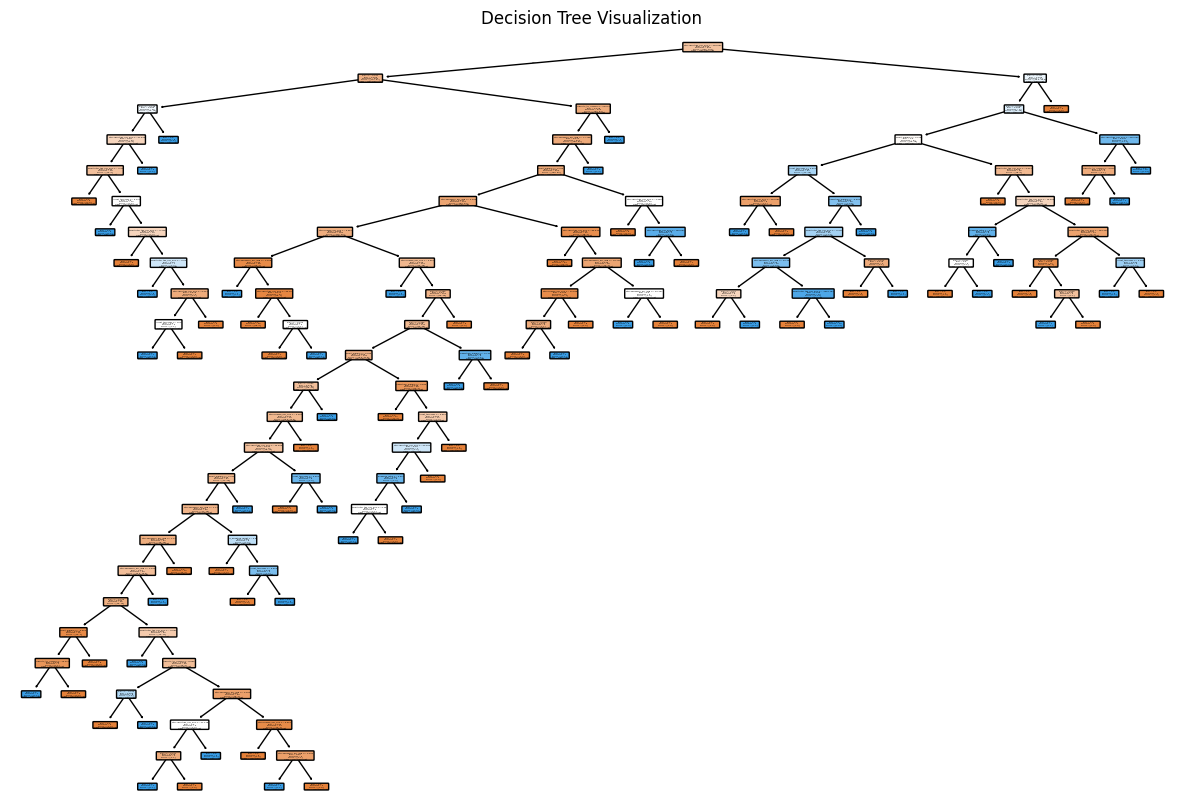

<ipython-input-14-66cb95fcdb60>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


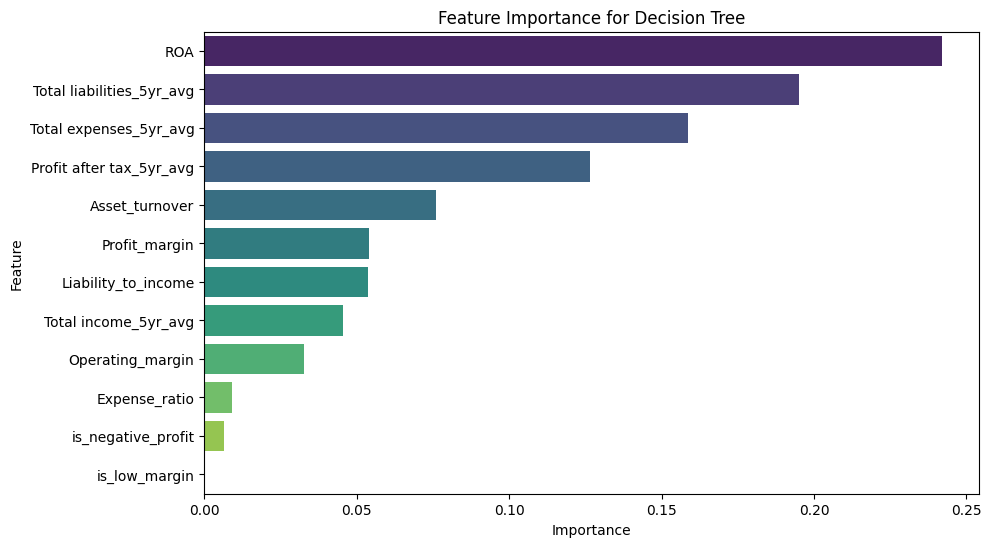

In [14]:
# Step 1: Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=42)

# Step 3: Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Step 4: Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = dt_model.predict(X_test)

# Step 6: Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

# Step 7: Visualize the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, filled=True, feature_names=features, class_names=["Non-Bankrupt", "Bankrupt"], rounded=True, proportion=False)
plt.title("Decision Tree Visualization")
plt.show()

# Step 8: Plot Feature Importances
feature_importances = dt_model.feature_importances_

# Create a DataFrame to view feature importances alongside feature names
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame based on importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance for Decision Tree")
plt.show()


✅ Accuracy: 0.34615384615384615

📉 Confusion Matrix:
 [[ 7 47]
 [ 4 20]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.13      0.22        54
           1       0.30      0.83      0.44        24

    accuracy                           0.35        78
   macro avg       0.47      0.48      0.33        78
weighted avg       0.53      0.35      0.28        78

Precision: 0.29850746268656714
Recall: 0.8333333333333334
F1 Score: 0.43956043956043955


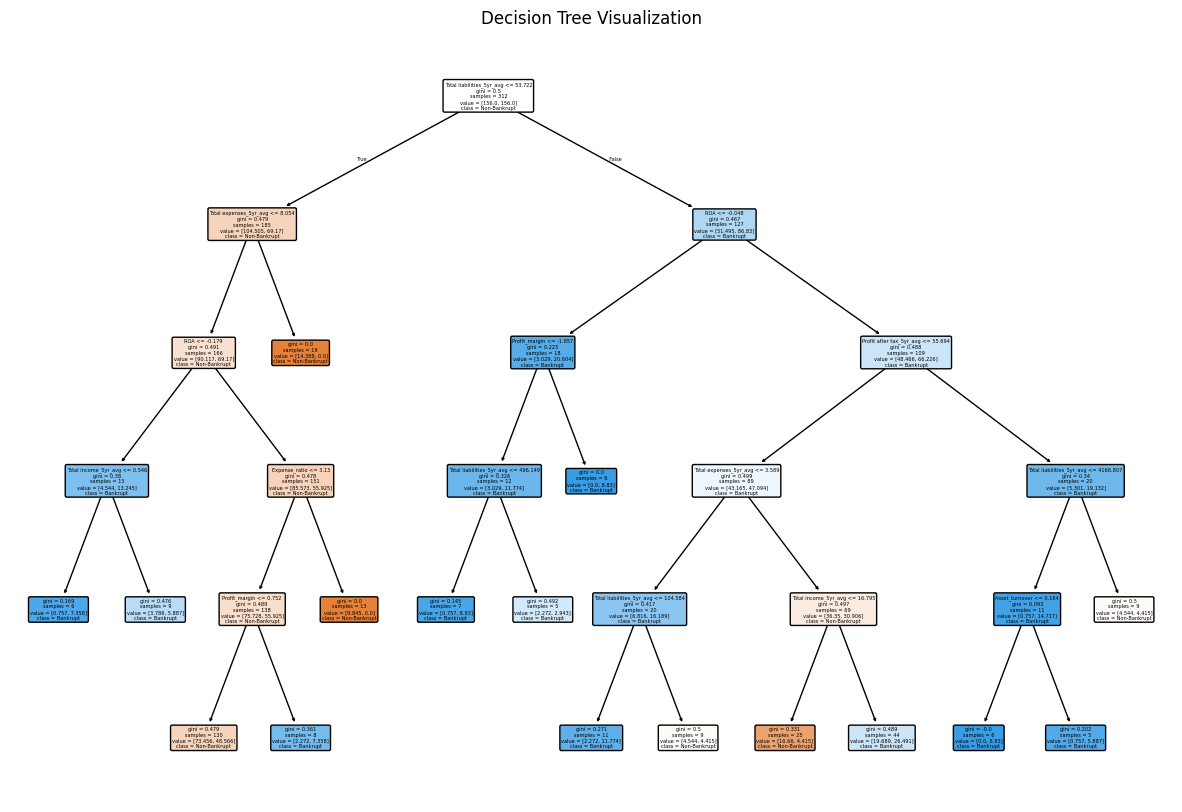

<ipython-input-15-b27316a0a750>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


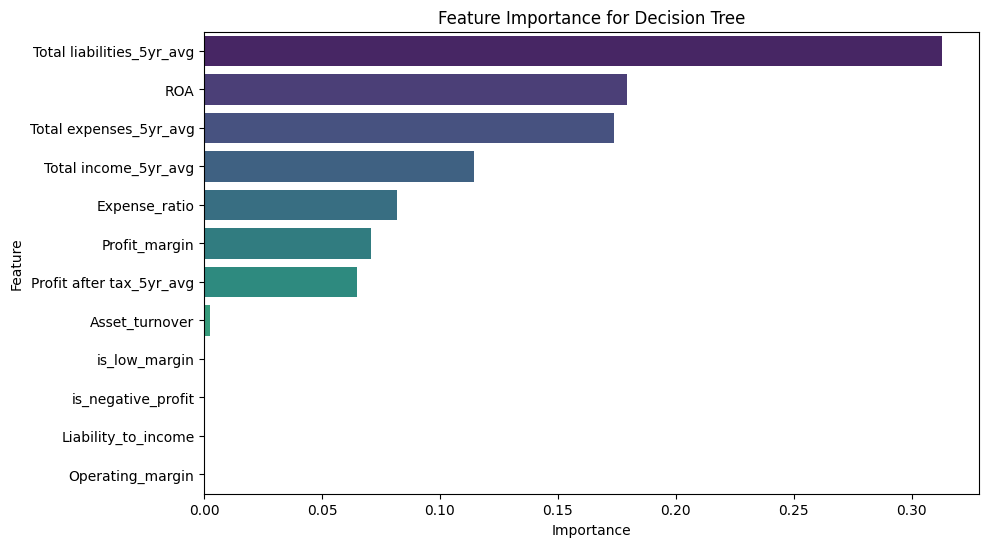

In [15]:
# Step 1: Import necessary libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=42)

# Step 3: Initialize the Decision Tree model with tuned parameters
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

# Step 4: Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Step 5: Predict probabilities and adjust threshold to improve recall
y_probs = dt_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.3).astype(int)  # Lowered threshold from 0.5 to 0.3

# Step 6: Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Step 7: Visualize the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, filled=True, feature_names=features, class_names=["Non-Bankrupt", "Bankrupt"], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Step 8: Plot Feature Importances
feature_importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance for Decision Tree")
plt.show()


✅ Accuracy: 0.3846
🎯 Precision: 0.3382
📈 Recall: 0.8846
📊 F1 Score: 0.4894
🧪 Best Threshold: 0.10

📉 Confusion Matrix:
 [[ 7 45]
 [ 3 23]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.13      0.23        52
           1       0.34      0.88      0.49        26

    accuracy                           0.38        78
   macro avg       0.52      0.51      0.36        78
weighted avg       0.58      0.38      0.31        78



<ipython-input-16-c00634258b7e>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


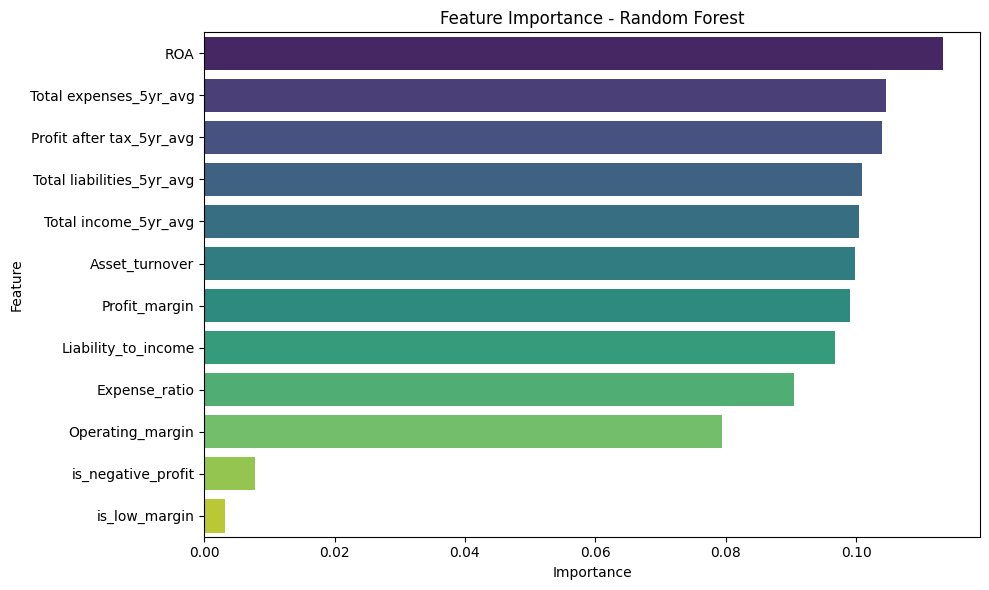

In [16]:
# Step 1: Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=42, stratify=Y_under)

# Step 4: Initialize Random Forest with class weight for imbalanced data
rf_model = RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Step 5: Predict probabilities for threshold tuning
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Step 6: Find best threshold to maximize F1-score
best_threshold = 0.5
best_f1 = 0
for t in np.arange(0.1, 0.9, 0.01):
    preds = (y_probs > t).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = t

# Step 7: Final predictions using best threshold
y_pred = (y_probs > best_threshold).astype(int)

# Step 8: Evaluate model
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"🎯 Precision: {precision_score(y_test, y_pred):.4f}")
print(f"📈 Recall: {recall_score(y_test, y_pred):.4f}")
print(f"📊 F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"🧪 Best Threshold: {best_threshold:.2f}")
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Step 9: Feature importance
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


✅ Accuracy: 0.5897435897435898

📉 Confusion Matrix:
 [[40 14]
 [18  6]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71        54
           1       0.30      0.25      0.27        24

    accuracy                           0.59        78
   macro avg       0.49      0.50      0.49        78
weighted avg       0.57      0.59      0.58        78

Precision: 0.3
Recall: 0.25
F1 Score: 0.2727272727272727


<ipython-input-17-0f93dad9eb31>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


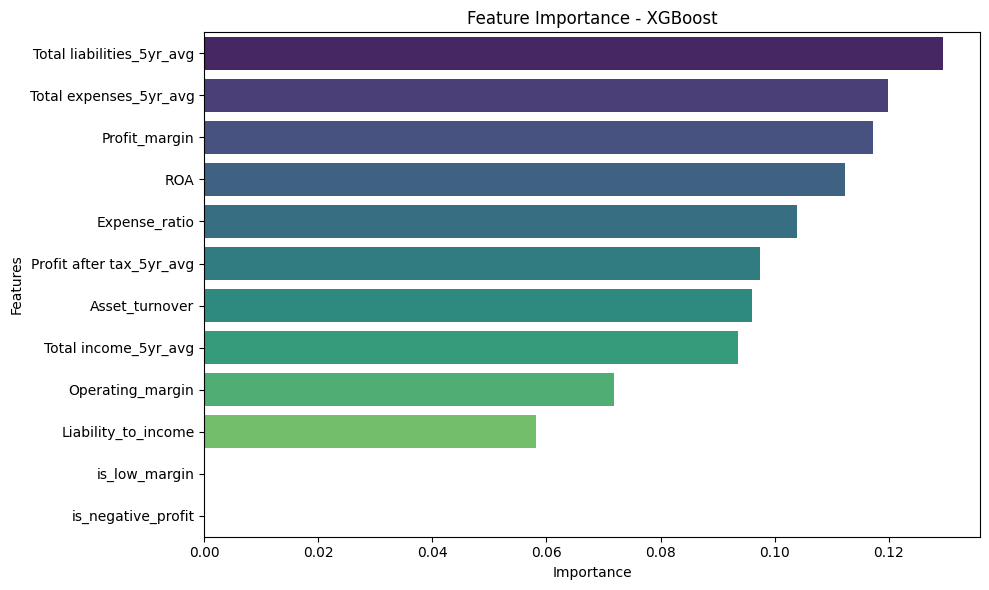

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=42)

# Step 2: Train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Step 3: Predict and evaluate
y_pred = xgb_clf.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

# Step 4: Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_clf.feature_importances_
})

# Sort the DataFrame based on importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 5: Plot the sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette="viridis"
)

plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


✅ Accuracy: 0.5897435897435898

📉 Confusion Matrix:
 [[35 19]
 [13 11]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69        54
           1       0.37      0.46      0.41        24

    accuracy                           0.59        78
   macro avg       0.55      0.55      0.55        78
weighted avg       0.62      0.59      0.60        78

📊 Precision: 0.36666666666666664
📈 Recall: 0.4583333333333333
📌 F1 Score: 0.4074074074074074


<ipython-input-18-68bce650b3b3>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted.values, y=importances_sorted.index, palette="Blues_d")


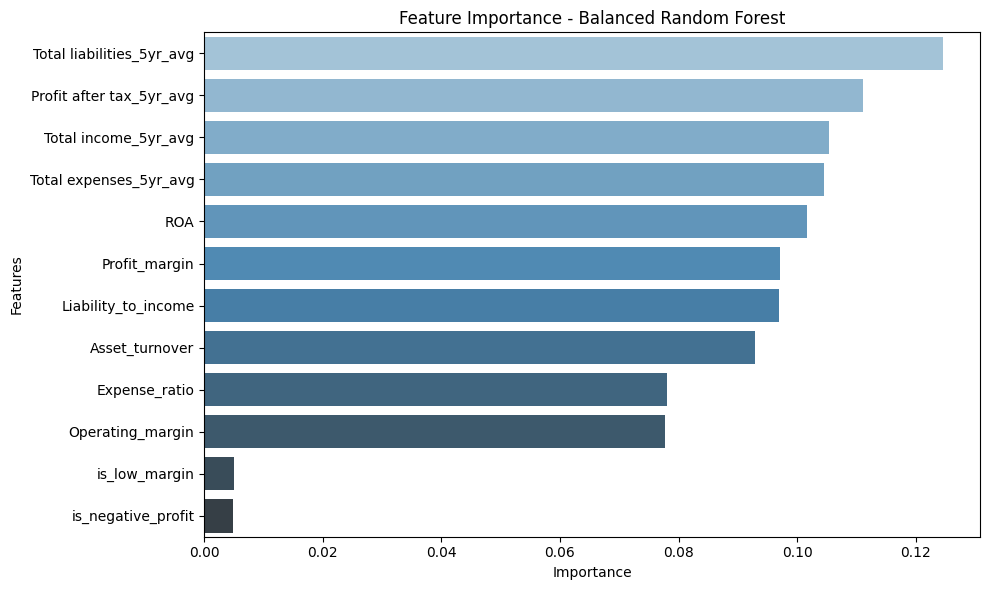

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 3: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_under, Y_under, test_size=0.2, random_state=42
)

# --- Step 4: Train Balanced Random Forest ---
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42
)
brf.fit(X_train, y_train)

# --- Step 5: Predictions ---
y_pred = brf.predict(X_test)

# --- Step 6: Evaluation ---
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

print("📊 Precision:", precision_score(y_test, y_pred))
print("📈 Recall:", recall_score(y_test, y_pred))
print("📌 F1 Score:", f1_score(y_test, y_pred))


# --- Step 7: Feature Importance ---
importances = pd.Series(brf.feature_importances_, index=features)
importances_sorted = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index, palette="Blues_d")
plt.title("Feature Importance - Balanced Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
